# Dataset Creation

- Using Vincent Van Gogh's artwork generate a series of paired images that are composed of a sketch and the true image.
- Add all data to a tensorflow dataset object and save.

### Setup

In [54]:
from pathlib import Path
from PIL import Image
from matplotlib import pyplot as plt
import tensorflow as tf
import cv2
import numpy as np

In [15]:
IMG_HEIGHT = 256
IMG_WIDTH = 256

IMG_DIR ='./wikiart/wikiart-test/'
IMG_EXTENSIONS = ['.png', '.jpg', '.jpeg']

### Load Images

Load images from directory which are horizontal and generate image paths.

Rotating an image in windows by right-clicking and using the 'rotate-left' and 'rotate-right' options do no change the orientation of the image according to PIL. This is due to EXIF tags and to obtain the correct result, edit the image itself in an image editor.

In [24]:
images_paths = set()
images_to_remove = set()

for ext in IMG_EXTENSIONS:
  images_paths = images_paths.union(Path(IMG_DIR).glob(f'**/*{ext}'))


for image_path in images_paths:
  image = Image.open(image_path)
  if image.size[0] < image.size[1]:
    images_to_remove.add(image_path)


images_paths.difference_update(images_to_remove)
images_paths = [str(image_path) for image_path in images_paths]


In [25]:
for image_path in images_paths:
    print(image_path)

wikiart\wikiart-test\images\vincent-van-gogh\1886\the-ravine-of-the-peyroulets-1889.jpg!Large.jpg
wikiart\wikiart-test\images\vincent-van-gogh\1885\the-green-wheatfield-behind-the-asylum-1889.jpg!Large.jpg
wikiart\wikiart-test\images\vincent-van-gogh\1887\the-reaper-1889.jpg!Large.jpg
wikiart\wikiart-test\images\vincent-van-gogh\1888\the-starry-night.jpg!Large.jpg


Open a sample image.

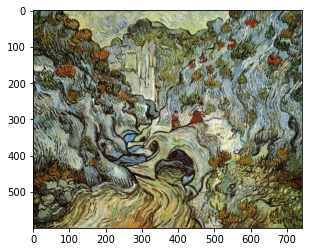

In [26]:
sample_image = tf.io.read_file((images_paths[0]))
sample_image = tf.io.decode_jpeg(sample_image)

plt.imshow(sample_image)

### Convert Images to Sketches

Using OpenCV convert image to grayscale, invert it and divide by inverted gaussian blur to get sketch like effect. 

In [76]:
def image_to_sketch(image_path):
    image1 = cv2.imread(image_path)
    
    grey_img = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    invert = cv2.bitwise_not(grey_img)

    blur = cv2.GaussianBlur(invert, (21, 21), 0)
    invertedblur = cv2.bitwise_not(blur)
    sketch = cv2.divide(grey_img, invertedblur, scale=256.0)
    
    sketch = cv2.cvtColor(sketch, cv2.COLOR_GRAY2BGR)

    return sketch

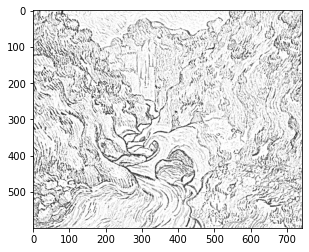

In [77]:
sketch = image_to_sketch(images_paths[0])
plt.imshow(sketch, cmap='gray')

### PIX2PIX Preprocessing

- Resize each 256 x 256 image to a larger height and width - 286 x 286.
- Randomly crop it back to 256 x 256.
- Randomly flip the image horizontally i.e. left to right (random mirroring).
- Normalize the images to the [-1, 1] range.

In [84]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [85]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [86]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [87]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [88]:
def load(image_path):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_path)
  image = tf.io.decode_jpeg(image)

  sketch = image_to_sketch(image_path)

  # Convert both images to float32 tensors
  input_image = tf.cast(sketch, tf.float32)
  real_image = tf.cast(image, tf.float32)

  return input_image, real_image

In [89]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [90]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

### Testing Pipeline for Single Image

This is for a single image where the sketch is generated and both images are sent via PIX2PIX preprocessing steps.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


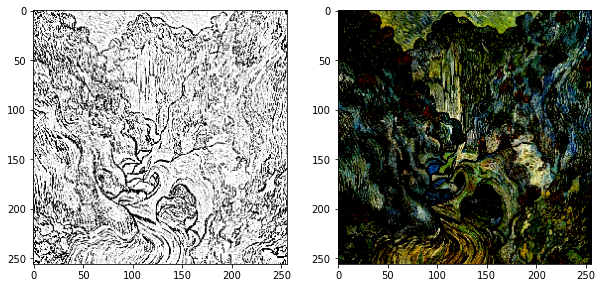

In [100]:
plt.figure(figsize=(10, 10))
input_image, real_image = load_image_train(images_paths[0])
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')

plt.subplot(1, 2, 2)
plt.imshow(real_image)

plt.show()
